In [70]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

from TransformerComplet import *

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention


In [71]:
# Chargement des fichiers CSV
# Chargement des fichiers CSV
benin_data = pd.read_csv("../../data/Bell_DNS Dataset/features_domain_benign_csv.csv")
malware_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_Malware.csv")
phishing_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_phishing.csv")
spam_data = pd.read_csv("../../data/Bell_DNS Dataset/features-domain_Spam.csv")

# Ajout de la colonne 'Class' 
benin_data['Class'] = 'Benin'
malware_data['Class'] = 'Malicious'
phishing_data['Class'] = 'Malicious'
spam_data['Class'] = 'Malicious'


In [73]:
# Séparation des fonctionnalités et de la cible

# Concaténation des ensembles de données
all_data = pd.concat([benin_data, malware_data, phishing_data, spam_data], ignore_index=True)



In [74]:
# Séparer les caractéristiques numériques et catégorielles

# X_numerical = all_data.select_dtypes(include='number')

X_numerical = all_data.select_dtypes(include=['int64', 'float64'])
X_categorical = all_data.select_dtypes(exclude='number').drop('Class', axis=1)

####### Avec selection des caracteristique RFECV


# X_numerical = all_data[['subdomain','entropy','Alexa_Rank']]
# X_categorical = all_data[['sld','char_distribution','2gram','distance_from_bad_words','shortened','Domain_Name']]

y = all_data['Class']



In [75]:
print(all_data['Class'].value_counts())
print(all_data['Class'].unique())



Class
Malicious    25910
Benin        24249
Name: count, dtype: int64
['Benin' 'Malicious']


In [76]:
print(all_data.shape)
print(X_numerical.shape)
print(X_categorical.shape)
X_numerical.var() ##affiche la vairance


(50159, 36)
(50159, 13)
(50159, 22)


subdomain             2.469210e-01
len                   5.041374e+01
numeric_percentage    4.878897e+01
entropy               3.723222e-01
dec_8                 0.000000e+00
dec_32                6.559620e-03
oc_8                  0.000000e+00
oc_32                 7.974164e-05
hex_8                 0.000000e+00
hex_32                0.000000e+00
puny_coded            4.682994e-03
Alexa_Rank            4.153903e+12
Page_Rank             0.000000e+00
dtype: float64

In [77]:
# print(X_numerical.info())
# print(X_categorical.info())


print(y.info())



<class 'pandas.core.series.Series'>
RangeIndex: 50159 entries, 0 to 50158
Series name: Class
Non-Null Count  Dtype 
--------------  ----- 
50159 non-null  object
dtypes: object(1)
memory usage: 392.0+ KB
None


In [ ]:
############### Ne pas executer ce code si je veux lancer l'entrainement sur tout les attribut ######################
############### Car le varianceTreshold() vas selectionner uniquement quelquues feautures ###########################
############### Ne pas executer ##############


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold # Por reduire les fonctionalités non i,portqntes en termes de variances



# 2. Vérification des colonnes vides
if X_numerical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques numériques
    numerical_imputer = SimpleImputer(strategy='mean')
    X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)

    #prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

    # Création d'un scaler
    scaler = MinMaxScaler()

    # Ajustement du scaler aux données
    scaler.fit(X_numerical_imputed)

    # Transformation des fonctionnalités numériques
    scaled_numeric_features = scaler.transform(X_numerical_imputed)


    print(scaled_numeric_features)

    # Apres transformation Création d' un DataFrame à partir des valeurs transformées

    scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical_imputed.columns)

    # Afficher le DataFrame avec les valeurs transformées
    print("Après transformation")
    print(scaled_df)

    # Création d'un objet VarianceThreshold avec la valeur de seuil 0.5
    variance_threshold = VarianceThreshold(threshold=0.005)

    # Appliquer la sélection de variance sur les attributs catégoriques encodés
    selected_features_num = variance_threshold.fit_transform(scaled_df)

    # Récupérer les noms des colonnes sélectionnées
    selected_columns = scaled_df.columns[variance_threshold.get_support()]

    # Créer un nouveau DataFrame avec les caractéristiques sélectionnées
    selected_features_df_num = pd.DataFrame(selected_features_num, columns=selected_columns)

    # Afficher le DataFrame résultant avec les caractéristiques sélectionnées
    print("Après sélection de variance")
    print(selected_features_df_num)

    # Afficher la taille du DataFrame avec les caractéristiques sélectionnées
    total_size_selected_num = selected_features_df_num.shape
    print("Taille totale des caractéristiques catégoriques après sélection de variance :", total_size_selected_num)
else:
    print("Pas de valeurs manquantes dans les caractéristiques numériques. Aucune imputation nécessaire.")


In [ ]:
########### Imputer les valeur categoricielle et encodage des features grace au label encoder ##########################
########################################################################################################################
######################## Ne pas executer ###############################################################################

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold

# 2. Vérification des colonnes vides
if X_categorical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques numériques
    categorical_imputer = SimpleImputer(strategy='most_frequent') ### autre on a [mean,constant,median]

    all_data_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical), columns=X_categorical.columns)


    print(all_data_categorical_imputed.dtypes)
    all_data_categorical_imputed = all_data_categorical_imputed.astype(str)

    # Encodage des variables catégorielles
     
    label_encoder = LabelEncoder()
    all_data_categorical_imputed_encoded = all_data_categorical_imputed.apply(label_encoder.fit_transform)

    print(all_data_categorical_imputed_encoded)


    ######################## je rehcehche la taille maximal attribue par le label encoder a une instance categoricielcar pour le passsage dans ma couche Embedding ################

    max_features = all_data_categorical_imputed_encoded.max().max()

    print("La taille maximal / le numero maximal d'une instance de mes features categoriques est : {} ",max_features )

    
    # Apres transformation Création d' un DataFrame à partir des valeurs transformées

    scaled_df_categoriciel = pd.DataFrame(all_data_categorical_imputed_encoded, columns=all_data_categorical_imputed_encoded.columns)

     # Afficher le DataFrame avec les valeurs transformées
    print("Après transformation")
    print(scaled_df_categoriciel)

    ################## Elimination des features non important en se basant sur la variance ##################

    # Création d'un objet VarianceThreshold avec la valeur de seuil 0.5
    variance_threshold = VarianceThreshold(threshold=0.05)

    # Appliquer la sélection de variance sur les attributs catégoriques encodés
    selected_features = variance_threshold.fit_transform(scaled_df_categoriciel)

    # Récupérer les noms des colonnes sélectionnées
    selected_columns = scaled_df_categoriciel.columns[variance_threshold.get_support()]

    # Créer un nouveau DataFrame avec les caractéristiques sélectionnées
    selected_features_df = pd.DataFrame(selected_features, columns=selected_columns)

    # Afficher le DataFrame résultant avec les caractéristiques sélectionnées
    print("Après sélection de variance")
    print(selected_features_df)

    # Afficher la taille du DataFrame avec les caractéristiques sélectionnées
    total_size_selected = selected_features_df.shape
    print("Taille totale des caractéristiques catégoriques après sélection de variance :", total_size_selected)

else:
    print("Pas de valeurs manquantes dans les caractéristiques Categoricel. Aucune imputation nécessaire.")


In [78]:
############################################  executer pour imputer les valeurs categoriceiel  ########################
#############################################################################################################################
##################################################################################


from sklearn.impute import SimpleImputer

# Imputer les valeurs manquantes pour les caractéristiques catégorielles

categorical_imputer = SimpleImputer(strategy='most_frequent')  
# categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical)) ## si je ne passe pas le deuxieme parametres pour dire de garder les noms de colones
# alors ce code car convertis le nom des colones en numerique  [0..n] et sa serai impossible de tokeniser ainsi si les noms de colonnes devient entier ###
categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical),columns=X_categorical.columns)

print(categorical_imputed)

            tld                     sld   
0           com                  google  \
1           com                  google   
2           com                  google   
3           com                  google   
4           com                facebook   
...         ...                     ...   
50154  xn--p1ai           xn--e1aawi3bw   
50155  xn--p1ai          xn--e1adw2cbtt   
50156  xn--p1ai            xn--i1adt7cc   
50157  xn--p1ai             xn--i1agwyy   
50158       com  zenithprivatebankingng   

                                       char_distribution   
0      defaultdict(<class 'int'>, {'g': 2, 'o': 2, 'l...  \
1      defaultdict(<class 'int'>, {'g': 2, 'o': 2, 'l...   
2      defaultdict(<class 'int'>, {'w': 3, 'g': 2, 'o...   
3      defaultdict(<class 'int'>, {'w': 3, 'g': 2, 'o...   
4      defaultdict(<class 'int'>, {'f': 1, 'a': 1, 'c...   
...                                                  ...   
50154  defaultdict(<class 'int'>, {'a': 2, '-': 2, 'w...   
501

In [79]:
########################### Imputaution des valeurs numeriques et Normalisation ######################
########################### A Executer #####################################################

from sklearn.impute import SimpleImputer


# 2. Vérification des colonnes vides
if X_numerical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques numériques
    numerical_imputer = SimpleImputer(strategy='mean')
    X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)

    #prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

    # Création d'un scaler
    scaler = MinMaxScaler()

    # Ajustement du scaler aux données
    scaler.fit(X_numerical_imputed)

    # Transformation des fonctionnalités numériques
    scaled_numeric_features = scaler.transform(X_numerical_imputed)


    print(scaled_numeric_features)

    # Apres transformation Création d' un DataFrame à partir des valeurs transformées

    scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical_imputed.columns)

    # Afficher le DataFrame avec les valeurs transformées
    print("Après transformation")
    print(scaled_df)

[[0.00000000e+00 3.89610390e-02 0.00000000e+00 ... 0.00000000e+00
  1.63603505e-07 0.00000000e+00]
 [0.00000000e+00 3.89610390e-02 0.00000000e+00 ... 0.00000000e+00
  1.63603505e-07 0.00000000e+00]
 [1.00000000e+00 5.84415584e-02 0.00000000e+00 ... 0.00000000e+00
  1.63603505e-07 0.00000000e+00]
 ...
 [0.00000000e+00 7.79220779e-02 1.23188406e-01 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.14285714e-02 6.43939394e-02 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.42857143e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Après transformation
       subdomain       len  numeric_percentage   entropy  dec_8  dec_32  oc_8   
0            0.0  0.038961            0.000000  0.384930    0.0     0.0   0.0  \
1            0.0  0.038961            0.000000  0.384930    0.0     0.0   0.0   
2            1.0  0.058442            0.000000  0.443538    0.0     0.0   0.0   
3            1.0  0.058442            0.000000  0.44353

In [80]:
all_columns = X_categorical.columns.tolist()

print(all_columns)



['tld', 'sld', 'char_distribution', '1gram', '2gram', '3gram', 'longest_word', 'distance_from_bad_words', 'typos', 'obfuscate_at_sign', 'shortened', 'Domain_Name', 'Registrar', 'Registrant_Name', 'Creation_Date_Time', 'Emails', 'Domain_Age', 'Organization', 'State', 'Country', 'Name_Server_Count', 'Unnamed: 34']


In [25]:
############### Ne pas executer car les features categoriciel sont encoder avec Label encoder puis Tokeniser ce qui peut degrader #######
######################### Comme jai deja encoder mes attribut categoriciel avec le LabelEncoder alors je ne tokenrise plus ##############
#########################################################################################################################################
#################### ici le Premier code a ne pas l'executer car la boucle for i in (1,11) n'ajoute que 11 token ########################
####################### Ne pas executer #################################################################################################



from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import pandas as pd


#Créer une copie du DataFrame pour éviter SettingWithCopyWarning

X_copy = X_categorical.copy()

# Convertir toutes les valeurs en chaînes de caractères
X_copy[all_data_categorical_imputed] = X_copy[all_data_categorical_imputed].astype(str)

# Convertir les caractéristiques catégorielles en codes numériques
label_encoder = LabelEncoder()
for feature in all_data_categorical_imputed:
    X_copy[feature] = label_encoder.fit_transform(X_copy[feature])

# Calculer la variance de chaque colonne catégorielle
variance_selector = VarianceThreshold(threshold=0.00)
X_copy_variance = variance_selector.fit_transform(X_copy[all_data_categorical_imputed])

# Récupérer les noms des colonnes ayant une variance suffisante
selected_features = [feature for feature, keep in zip(all_data_categorical_imputed, variance_selector.get_support()) if keep]

# Convertir les valeurs de la colonne en chaînes de caractères
X_copy[selected_features] = X_copy[selected_features].astype(str)

# Combinaison des features textuelles avec un séparateur
# # X_copy['combined_text'] = X_copy[categorical_features].apply(lambda row: ' SEPARATOR '.join(row), axis=1)

X_copy['combined_text'] = X_copy[selected_features].apply(lambda row: ' '.join(row), axis=1)


# Tokenisation des textes combinés

# tokenizer = Tokenizer(num_words=10, filters='', split=' SEPARATOR ')

#Avec le separator les donnee ne sont pas bien combinée il y'a  les tokens vide et la longueur max c'est 1 d'ou c'est pas bon    

tokenizer = Tokenizer(num_words=10, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Ajout des colonnes tokenisées au DataFrame
for i in range(1, max_sequence_length + 1):
    X_copy[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
X_copy.drop(columns=all_data_categorical_imputed + ['combined_text'], inplace=True)

# Afficher les tokens et les longueurs de séquence
print("Tokens:")
print(tokens)

# Afficher le nombre total de tokens
print("Nombre total de tokens:", len(tokens))

print("\nLongueurs de séquence:")
print([len(seq) for seq in tokens])

#je garde les les sequences
seq_l = [len(seq) for seq in tokens]

# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur : {max_sequence_length}")


Tokens:
[[1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1, 2], [1, 2], [1], [1], [1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1], [1], [1, 5], [1, 5], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1], [1], [1, 2], [1, 2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1, 2], 

In [81]:
######################### A executer ######################################################################
######################################################################################################################
#################### ici le Premier code a ne pas l'executer car la boucle for i in (1,11) n'ajoute que 11 token ###############################################

from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd


#Créer une copie du DataFrame pour éviter SettingWithCopyWarning

#X_copy = X_categorical.copy()   ### je creais une copie sur les donnee categorique initiales et non ceux ayant été imputer des valeurs manquqntes

X_copy = categorical_imputed.copy()  ## je creais une copy sur les données imputer

# Appliquer une tokenisation à chaque colonne catégorielle
for feature in all_data_categorical_imputed:
    X_copy[feature] = X_copy[feature].astype(str)


# Combinaison des features textuelles avec un séparateur
    
# X_copy['combined_text'] = X_copy[categorical_features].apply(lambda row: ' SEPARATOR '.join(row), axis=1)
    
#Avec le separator les donnee ne sont pas bien combinée il y'a  les tokens vide et la longueur max c'est 1 d'ou c'est pas bon    
  
X_copy['combined_text'] = X_copy[all_data_categorical_imputed].apply(lambda row: ' '.join(row), axis=1)

# Tokenisation des textes combinés

# tokenizer = Tokenizer(num_words=10, filters='', split=' SEPARATOR ')

#Avec le separator les donnee ne sont pas bien combinée il y'a  les tokens vide et la longueur max c'est 1 d'ou c'est pas bon    

tokenizer = Tokenizer(num_words=10, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Ajout des colonnes tokenisées au DataFrame
for i in range(1, max_sequence_length + 1):
    X_copy[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
X_copy.drop(columns=all_data_categorical_imputed + ['combined_text'], inplace=True)

# Afficher les tokens et les longueurs de séquence
print("Tokens:")
# print(tokens) ## c'est trop long
print(tokens)

print("\nLongueurs de séquence:")
print([len(seq) for seq in tokens])

#je garde les les sequences

seq_l = [len(seq) for seq in tokens]


# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur : {max_sequence_length}")


Tokens:
[[2, 8, 9, 3, 3, 1, 7, 5, 6, 4, 2], [2, 8, 9, 3, 3, 1, 7, 5, 6, 4, 2], [2, 8, 9, 3, 3, 1, 7, 5, 6, 4, 2], [2, 8, 9, 3, 3, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 1, 1, 3, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 1, 1, 3, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 1, 1, 3, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 1, 1, 3, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 1, 1, 3, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 1, 1, 3, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 3, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 3, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 3, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 3, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 1, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 1, 1, 1, 3, 1, 1, 7, 5, 6, 4, 2], [2, 8, 9, 1, 

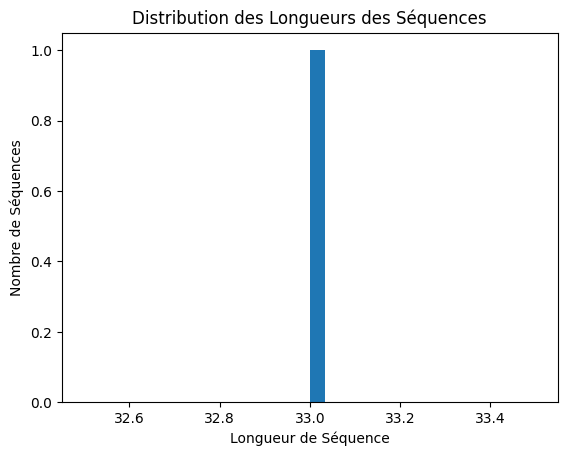

In [82]:


mean_length = np.mean(max_sequence_length)
max_length = np.max(max_sequence_length)
min_length = np.min(max_sequence_length)
std_dev = np.std(max_sequence_length)

# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(max_sequence_length, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()

In [83]:
# Hyperparamètres et dimensions des données*
taille_num_features = scaled_df.shape[1]
taille_text_features = max_sequence_length 
#taille_text_features = X_categorical.shape[1]  (Quand je n'applique pas la methode de selection des caracteristiques basé sur la variance ie le nbre de feature reste fixe) # je donne la taille max parmi les longueur des sequences

vocab_size = 20000 

embedding_dim = 128   ### profondeur du embedding quand j'utilise le tokeniser pour encoder mes donnee par contre quand c'es le lable encoder je change comme ceci ##


In [84]:
# Entrées

input_num = tf.keras.layers.Input(shape=(taille_num_features,))
input_text = tf.keras.layers.Input(shape=(taille_text_features,))


# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(64, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(32, activation='relu')(num_branch)


# Branche textuelle - Embedding + LSTM
# Branche textuelle - Embedding + Transformer (Un block)

################# Ce embedding si c'est lorque j'utilise les tokeniser pour encoder mes attribut categorciel car la taille des input n'est pas trop grand

# text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)

#### avec le label encoder je modifie comme ceci 
text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)
mask_inputs = masque_remplissage(input_text) 
out_seq = Encodeur(
        n_layers=4, d_model=128, num_heads=4,
        middle_units=256, max_seq_len=taille_text_features)([text_branch, mask_inputs])
out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)

# Fusion des branches 

# Fusion des branches 

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])

In [85]:
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate, Dropout

# Couches supplémentaires après la fusion
merged = Dropout(0.5)(merged)
merged = Dense(16, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(merged) 


In [86]:
from tensorflow.keras.optimizers import Adam


# Création et compilation du modèle

model = Model(inputs=[input_num, input_text], outputs=output)

# opt = Adam(learning_rate=0.0001, decay=0.00001)

opt = Adam(learning_rate=0.0001)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [87]:
print(model.summary())


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 dense_86 (Dense)               (None, 64)           896         ['input_7[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 33, 128)      2560000     ['input_8[0][0]']                
                                                                                            

In [89]:
from tensorflow.keras.preprocessing.sequence import pad_sequences



labels = all_data['Class']

# Entrées pour l'entraînement

#data_num = scaled_numeric_features
#data_text = pad_sequences(tokens, maxlen=max_length,padding='post') ##### quqnd j'utilise la tokenrisation pour encoder mes variables categoriciel je dois proceder ainsi #########

data_num = scaled_df
data_text = pad_sequences(tokens, maxlen=max_sequence_length,padding='post')
print(labels)



0            Benin
1            Benin
2            Benin
3            Benin
4            Benin
           ...    
50154    Malicious
50155    Malicious
50156    Malicious
50157    Malicious
50158    Malicious
Name: Class, Length: 50159, dtype: object


In [90]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Encodage de la cible en labels numériques
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(y_encoded)


[0 0 0 ... 1 1 1]


In [91]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.2, random_state=42
)

In [34]:
print("Shape of text_train:", text_train.shape)
print("Shape of labels_train:", labels_train.shape)
print("Shape of text_test:", text_test.shape)
print("Shape of labels_test:", labels_test.shape)
print("Shape of num_train:", num_train.shape)
print("Shape of num_test:", num_test.shape)

print("Visualisation des dimension et du batch_size\n")

batch_size, dimension = text_train.shape[0], text_train.shape[1]
print("Batch size text train:", batch_size)
print("Dimension text train:", dimension)

batch_size, dimension = num_train.shape[0], num_train.shape[1]
print("Batch size num train:", batch_size)
print("Dimension num train:", dimension)



Shape of text_train: (40127, 37)
Shape of labels_train: (40127,)
Shape of text_test: (10032, 37)
Shape of labels_test: (10032,)
Shape of num_train: (40127, 13)
Shape of num_test: (10032, 13)
Visualisation des dimension et du batch_size

Batch size text train: 40127
Dimension text train: 37
Batch size num train: 40127
Dimension num train: 13


In [ ]:
# Afficher quelques exemples des données d'entraînement
print("Exemples des données d'entraînement:")
print("Text_train:")
print(text_train[:5])
print("\nNum_train:")
print(num_train[:5])
print("\nLabels_train:")
print(labels_train[:5])

# Faire de même pour les données de test


# Vérifier si des valeurs nan sont présentes
print("\nVérification des valeurs nan:")
print("Text_train contains nan:", np.isnan(text_train).any())
print("Num_train contains nan:", np.isnan(num_train).any())
print("Labels_train contains nan:", np.isnan(labels_train).any())

# Faire de même pour les données de test



In [ ]:
##############Verification de nouveau


# Afficher quelques exemples des données d'entraînement
print("Exemples des données d'entraînement:")
print("Text_train:")
print(text_train[:5])
print("\nNum_train:")
print(num_train[:5])
print("\nLabels_train:")
print(labels_train[:5])

# Faire de même pour les données de test


# Vérifier si des valeurs nan sont présentes
print("\nVérification des valeurs nan:")
print("Text_train contains nan:", np.isnan(text_train).any())
print("Num_train contains nan:", np.isnan(num_train).any())
print("Labels_train contains nan:", np.isnan(labels_train).any())

# Faire de même pour les données de test



In [92]:
### A ne pas executer  car j'execute cela lors de la recherche des HytperParametre

history = model.fit([num_train,text_train], labels_train, epochs=60, batch_size=32, validation_data=([num_test,text_test], labels_test))


Train on 40127 samples, validate on 10032 samples
Epoch 1/60
40127/40127 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.6897

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


40127/40127 [==============================] - 83s 2ms/sample - loss: 0.5732 - accuracy: 0.6897 - val_loss: 0.5357 - val_accuracy: 0.7209
Epoch 2/60
40127/40127 [==============================] - 73s 2ms/sample - loss: 0.5318 - accuracy: 0.7262 - val_loss: 0.5164 - val_accuracy: 0.7409
Epoch 3/60
40127/40127 [==============================] - 71s 2ms/sample - loss: 0.5069 - accuracy: 0.7452 - val_loss: 0.4771 - val_accuracy: 0.7720
Epoch 4/60
40127/40127 [==============================] - 75s 2ms/sample - loss: 0.4805 - accuracy: 0.7621 - val_loss: 0.4536 - val_accuracy: 0.7816
Epoch 5/60
40127/40127 [==============================] - 83s 2ms/sample - loss: 0.4589 - accuracy: 0.7755 - val_loss: 0.4301 - val_accuracy: 0.7959
Epoch 6/60
40127/40127 [==============================] - 77s 2ms/sample - loss: 0.4415 - accuracy: 0.7872 - val_loss: 0.4139 - val_accuracy: 0.8106
Epoch 7/60
40127/40127 [==============================] - 87s 2ms/sample - loss: 0.4280 - accuracy: 0.7939 - val_loss

In [93]:
#on effectue les prediction sur les donnees de test

y_pred = model.predict([num_test,text_test])

print(y_pred)

# necessaire pour afficher la matrix de confusion car a besoin que la probabilité retourner pqr lq fonction sigmoid soir saoit 0 ou 1 pour travailler dessus

y_pred = np.round(y_pred)

c:\python install\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[0.12068639]
 [0.7616241 ]
 [0.02244213]
 ...
 [0.12027826]
 [0.79130703]
 [0.00726949]]


In [94]:
from sklearn.metrics import classification_report


# Évaluation du modèle sur les données de test

evaluation_results = model.evaluate([num_test, text_test], labels_test)


# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Perte sur les données de test:", evaluation_results[0])
print("Précision sur les données de test:", evaluation_results[1])


# Afficher le rapport de classification
class_report = classification_report(labels_test, y_pred)
print("Rapport de classification :\n", class_report)



Perte sur les données de test: 0.33327022166343395
Précision sur les données de test: 0.8546651
Rapport de classification :
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      4843
           1       0.83      0.90      0.87      5189

    accuracy                           0.85     10032
   macro avg       0.86      0.85      0.85     10032
weighted avg       0.86      0.85      0.85     10032



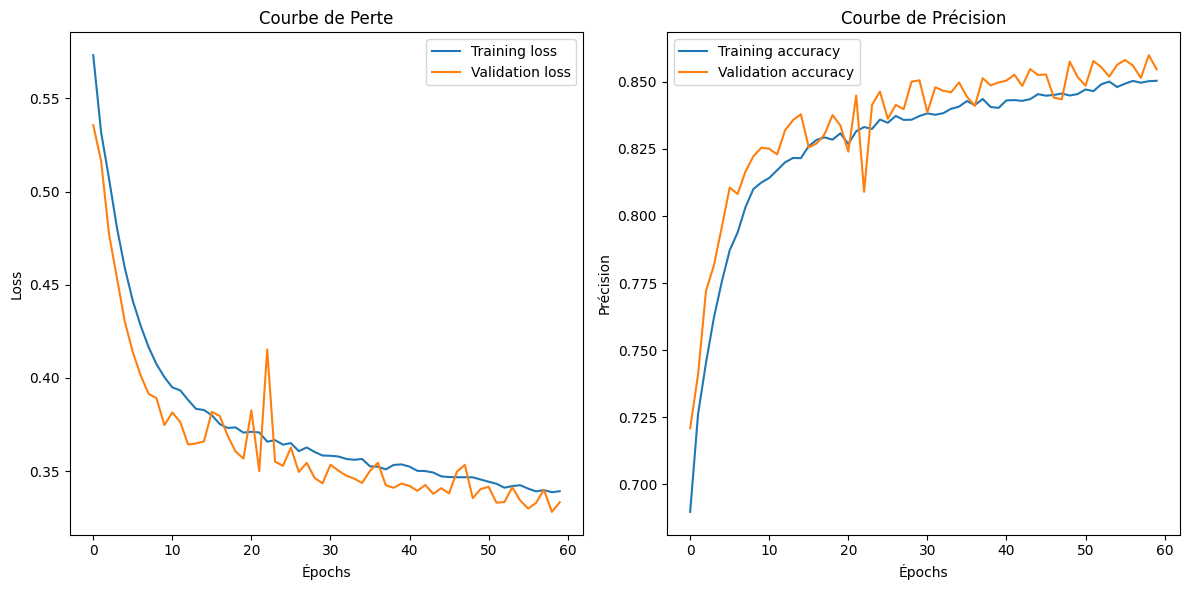

In [95]:
# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

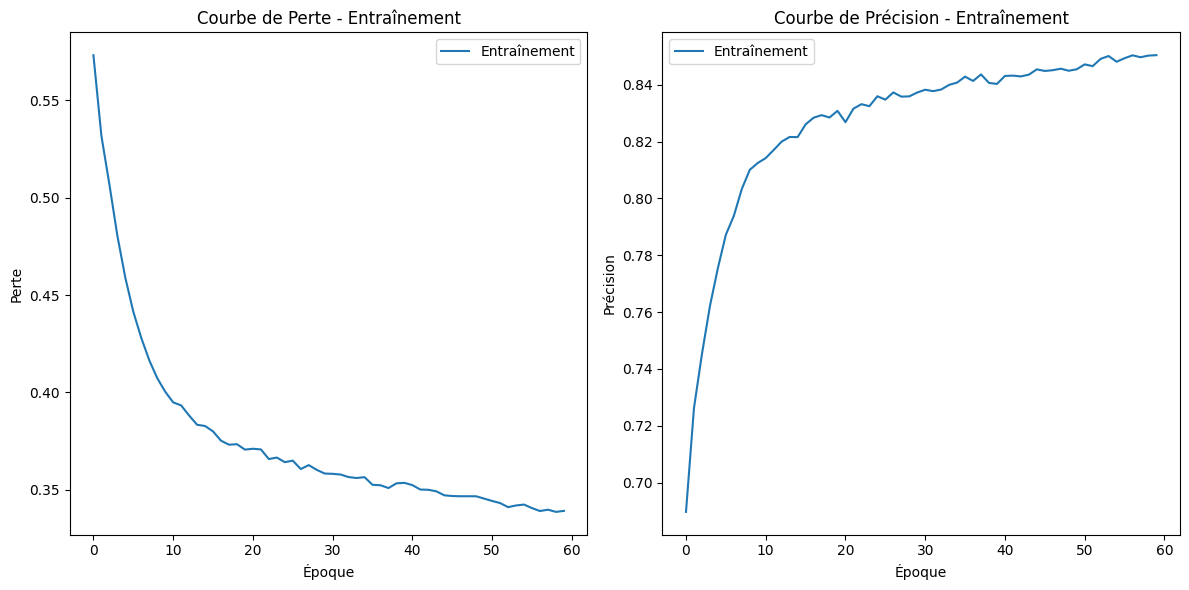

In [101]:

# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entraînement')
plt.title('Courbe de Perte - Entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

# Plot de la précision d'entraînement
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Entraînement')
plt.title('Courbe de Précision - Entraînement')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()


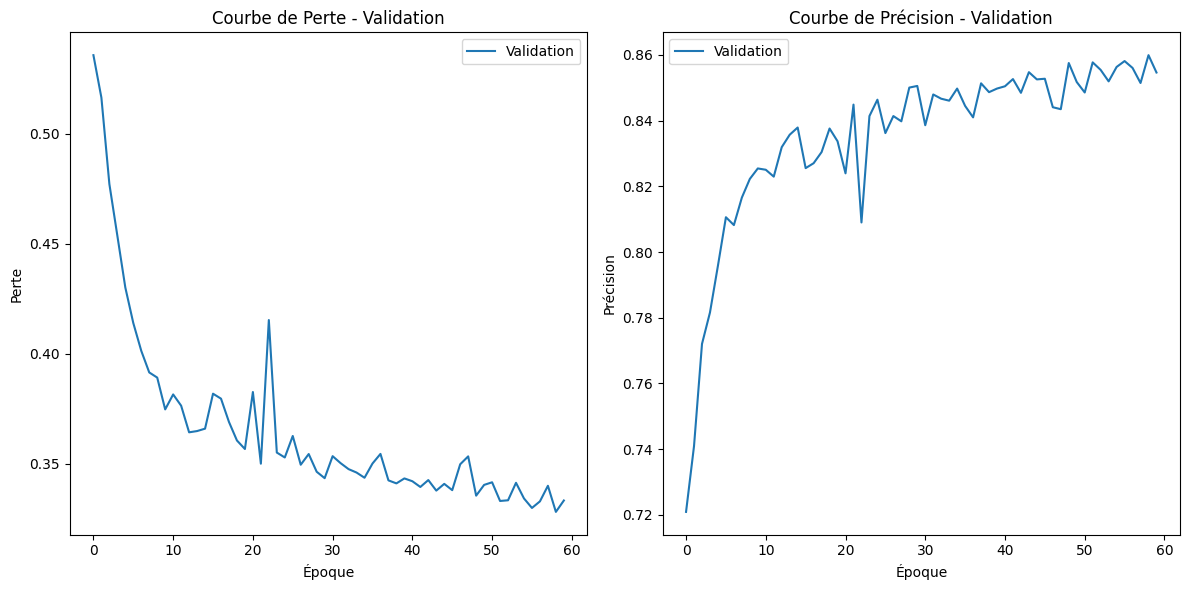

In [102]:

# Affichage des courbes de validation
plt.figure(figsize=(12, 6))

# Plot de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Courbe de Perte - Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

# Plot de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Courbe de Précision - Validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()


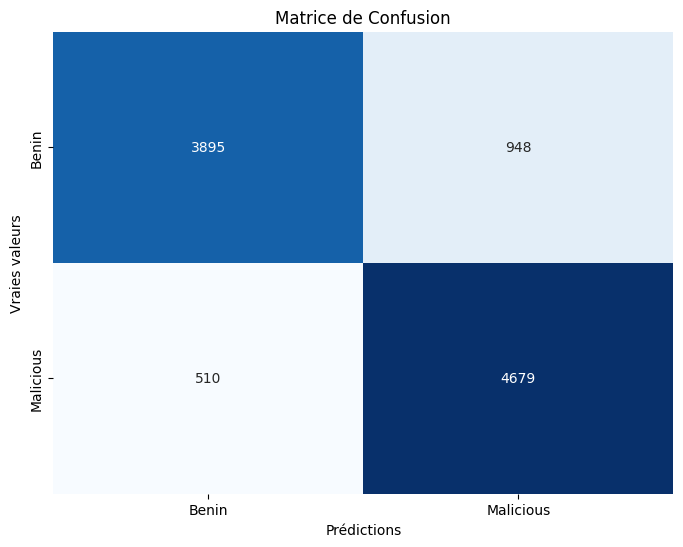

In [97]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, roc_curve, auc



# Matrice de confusion
conf_matrix = confusion_matrix(labels_test, y_pred)
class_names = ['Benin', 'Malicious']
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()

In [ ]:
############################################ Marche tres bien ############
################################## En utilisant le BayesianOptimization() et le ModelChekpoint qui detient le meilleur model ] #######################


##### Hyper parametre Tuning
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.metrics import AUC


from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import BayesianOptimization




# Définir la fonction pour la recherche des hyperparamètres
def build_model(hp):
    model = Model(inputs=[input_num, input_text], outputs=output)

    # Définir les hyperparamètres à optimiser
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    hp_lstm_units = hp.Choice('lstm_units', values=[64, 128, 256])
    hp_dense_units = hp.Choice('dense_units', values=[16, 32, 64])
    hp_embedding_dim = hp.Choice('embedding_dim', values=[64, 128, 256])

    # Compiler le modèle avec les hyperparamètres
    # optimizer = Adam(lr=hp_learning_rate)

    optimizer = Adam(learning_rate=hp_learning_rate)

    # model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', AUC()])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    return model

# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.2, random_state=42
)

#Pour resoudre les erreur 
import os

# Vérifier si le répertoire existe, sinon le créer
save_directory = 'my_dir'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Créer un tuner pour la recherche des hyperparamètres

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    hyperparameters=HyperParameters(),
    directory=save_directory,
    project_name='lstm_ffn_hyperparam_tuning'
)

# Définir un callback ModelCheckpoint pour sauvegarder le meilleur modèle
filepath=os.path.abspath('my_dir/lstm_ffn_hyperparam_tuning/best_model.h5')

checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


# Rechercher les meilleurs hyperparamètres en utilisant les données d'entraînement et de validation
# Utiliser le callback BayesianOptimizationCallback

tuner.search([num_train, text_train], labels_train, epochs=5, validation_data=([num_test, text_test], labels_test), callbacks=[checkpoint_callback])

# Obtenir les meilleurs hyperparamètres trouvés
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best hyperparameters: {best_hps}")

# Réutiliser les meilleurs hyperparamètres pour construire le modèle final
model = build_model(best_hps)

# Entraîner le modèle avec les données complètes
model.fit([num_train, text_train], labels_train, epochs=5, batch_size=32, validation_data=([num_test, text_test], labels_test))



##############################################################################################################


############################################ Marche tres bien ############
################################## En utilisant le BayesianOptimization() et le ModelChekpoint qui detient le meilleur model ] #######################


##### Hyper parametre Tuning
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.metrics import AUC


from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import BayesianOptimization




# Définir la fonction pour la recherche des hyperparamètres
def build_model(hp):
    model = Model(inputs=[input_num, input_text], outputs=output)

    # Définir les hyperparamètres à optimiser
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    hp_lstm_units = hp.Choice('lstm_units', values=[64, 128, 256])
    hp_dense_units = hp.Choice('dense_units', values=[16, 32, 64])
    hp_embedding_dim = hp.Choice('embedding_dim', values=[64, 128, 256])

    # Compiler le modèle avec les hyperparamètres
    # optimizer = Adam(lr=hp_learning_rate)
    optimizer = Adam(learning_rate=hp_learning_rate)

    # model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', AUC()])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    return model

# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y_encoded, test_size=0.2, random_state=42
)

#Pour resoudre les erreur 
import os

# Vérifier si le répertoire existe, sinon le créer
save_directory = 'my_dir'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Créer un tuner pour la recherche des hyperparamètres

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    hyperparameters=HyperParameters(),
    directory=save_directory,
    project_name='lstm_ffn_hyperparam_tuning'
)

# Définir un callback ModelCheckpoint pour sauvegarder le meilleur modèle
filepath=os.path.abspath('my_dir/lstm_ffn_hyperparam_tuning/best_model.h5')

checkpoint_callback = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


# Rechercher les meilleurs hyperparamètres en utilisant les données d'entraînement et de validation
# Utiliser le callback BayesianOptimizationCallback

tuner.search([num_train, text_train], labels_train, epochs=5, validation_data=([num_test, text_test], labels_test), callbacks=[checkpoint_callback])

# Obtenir les meilleurs hyperparamètres trouvés
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best hyperparameters: {best_hps}")

# Réutiliser les meilleurs hyperparamètres pour construire le modèle final
model = build_model(best_hps)

# Entraîner le modèle avec les données complètes
history = model.fit([num_train, text_train], labels_train, epochs=5, batch_size=32, validation_data=([num_test, text_test], labels_test))
